In [3]:
import numpy as np
np.random.seed(1)

from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from scipy.optimize import fsolve

In [4]:
x1, x2 = np.array([1., 0.]), np.array([0., 1.])

def sigma(y):
    
    if y<0.05:
        return 0.05
    else:
        return y#1.5*np.tanh(y)
    
def sigma_inverse(x):

    if x<=0.05:
        return "ERROR: sigma is not invertible here"
    else:
        return x

invertibility_domain_sigma = (0.05, 100)

In [5]:
def get_stationary_points(R1, R2):

    critical_points = {}

    critical_points["(0,0)"]          = (0,0)
    critical_points["(0,theta)"]      = None
    critical_points["(0,bary2)"]      = (0, sigma_inverse(R2/(R2-R1)))
    critical_points["(theta,0)"]      = None
    critical_points["(theta,theta)"]  = (1, 1)
    critical_points["(theta,bary2)"] = None
    critical_points["(bary1,0)"]     = (sigma_inverse(R1/(R1-R2)), 0)
    critical_points["(bary1,theta)"] = None
    critical_points["(bary1,bary2)"] = (sigma_inverse(R1/(R1-R2)), sigma_inverse(R2/(R2-R1)))

    sigma_bary1 = R1/(R1-R2)
    sigma_bary2 = R2/(R2-R1)

    def left_member(x):
        return sigma(0)/(sigma(0)+ sigma(x))*x**2

    def right_member(x):
        return x
    
    def func_to_solve(x):
        return left_member(x) - right_member(x)
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(0,theta)"] = (0, solution)
    critical_points["(theta,0)"] = (solution, 0)


    def left_member(x):
        norm = sigma_bary2+sigma(x)
        return sigma_bary2 / norm * x**2 + sigma(x)/norm * sigma_inverse(sigma_bary2)**2
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(theta,bary2)"] = (solution, sigma_inverse(R2/(R2-R1)) )


    def left_member(x):
        norm = sigma_bary1+sigma(x)
        return sigma(x) / norm * sigma_inverse(sigma_bary1)**2 + sigma_bary1/norm * x**2
    
    solution = fsolve(func_to_solve, x0=0)
    critical_points["(bary1,theta)"] = (sigma_inverse(R1/(R1-R2)), solution)

    return critical_points

In [6]:
def get_vector_field(initial_conditions, R1, R2):

    vector_field = []

    for (y1,y2) in initial_conditions:

        p12 = sigma(y2)
        p22 = 1 - p12
        p21 = sigma(y1)
        p11 = 1 - p21 

        p1 = p12/(p12+p21)
        p2 = p21/(p12+p21)

        theta = p1*y1**2 + p2*y2**2

        delta_w = p11*R1*x1*y1*(y1-theta) + p21*R2*x1*y1*(y1-theta) + p12*R1*x2*y2*(y2-theta) + p22*R2*x2*y2*(y2-theta)

        vector_field.append(delta_w)

    vector_field = np.array(vector_field)

    vector_field_normalized = np.array(vector_field) /  np.sqrt((np.array(vector_field)**2).sum(axis=1, keepdims=True))

    return vector_field_normalized

In [7]:
def add_arrow(line, position=None, direction='right', size=20, color=None):
    """
    add an arrow to a line.

    line:       Line2D object
    position:   x-position of the arrow. If None, mean of xdata is taken
    direction:  'left' or 'right'
    size:       size of the arrow in fontsize points
    color:      if None, line color is taken.
    """
    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="->", color=color, lw=2),
        size=size
    )


def make_plot(ax, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectory):

    for key in critical_points:


        if (R1==1 and key == "(bary1,theta)") or (R2==1 and key=="(theta,bary2)"):
            color = 'red'
            size=5
        else:
            color = 'blue'
            size=3

        ax.plot(*critical_points[key], 'o', c=color, ms=size)

    ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
            vector_field_normalized[:, 0], vector_field_normalized[:,1])


    ax.set_xticks([0.0, 0.4, 0.8, 1.2])
    ax.set_yticks([0.0, 0.4, 0.8, 1.2])

    ax.set_xlabel("$w_1$")
    ax.set_ylabel("$w_2$")

    ax.set_aspect('equal')

    
    end_phase_1 = 150
    
    if R1==1:
        ax.set_title("Phase 1")
        stability_basin = (1.5, 0.6)
        ax.plot(trajectory[:end_phase_1, 0], trajectory[:end_phase_1, 1], color='black', lw=1.5, label='example trajectory')
        

    else:
        ax.set_title("Phase 2")
        stability_basin = (0.6, 1.5)

        ax.plot(trajectory[end_phase_1:, 0], trajectory[end_phase_1:, 1], color='black', lw=1.5, label='example trajectory')
        

    rect = Rectangle((0., 0.), *stability_basin, linewidth=1, edgecolor='none', facecolor='green', alpha=0.15, label='basin of attraction')
    ax.add_patch(rect)

    if R2==1:
        ax.plot(trajectory[:end_phase_1, 0], trajectory[:end_phase_1, 1], color='gray', lw=1.5, label='trajectory of phase 1')

    ax.set_xlim(-0.2, 1.2)
    ax.set_ylim(-0.2, 1.2)

    ax.legend(loc='upper left')

In [8]:
def change_state(x, x1, x2):

    if np.array_equal(x, x1):
        return x2.copy()
    
    elif np.array_equal(x, x2):
        return x1.copy()

def get_valence_signal(x, x1, x2, R1, R2):

    if np.array_equal(x, x1):
        return R1
    elif np.array_equal(x, x2):
        return R2
    

class Model:
    
    def __init__(self, theta0, block_threshold, eta_w, eta_theta):

        self.eta_w = eta_w
        self.eta_theta = eta_theta

        self.theta = theta0

        self.block_threshold = block_threshold
    
    def get_weights_update(self, x, y, R):

        theta_dot = - self.eta_theta * (self.theta - y**2)

        w_dot = self.eta_w*R*x*y*(y - self.theta)
        
        if not self.block_threshold:
            
            self.theta = self.theta + theta_dot
        
        return w_dot

steps = 40000
sample_rate = 100

starting_point = (0.2, 0.3)

w = np.array(starting_point)

theta = 0
eta_w = 0.01
eta_theta = 0.02

R1 = 1
R2 = -1.5

x = x1.copy()

model = Model(theta, False, eta_w, eta_theta)

trajectory = [w.copy(), ]

for step in tqdm(range(steps)):
    
    x_old = x.copy()

    y = np.dot(w, x)

    p_change = sigma(y)

    if np.random.rand()< p_change:
        
        x = change_state(x, x1, x2)
    
    if step==15000:
        R1 = -1.5
        R2 = 1
    R = get_valence_signal(x, x1, x2, R1, R2)
    w += model.get_weights_update(x_old, y, R)

    if step%sample_rate==sample_rate-1:
        trajectory.append(w.copy())

trajectory = np.array(trajectory)

100%|██████████| 40000/40000 [00:00<00:00, 168866.24it/s]


(-0.01, 0.03)

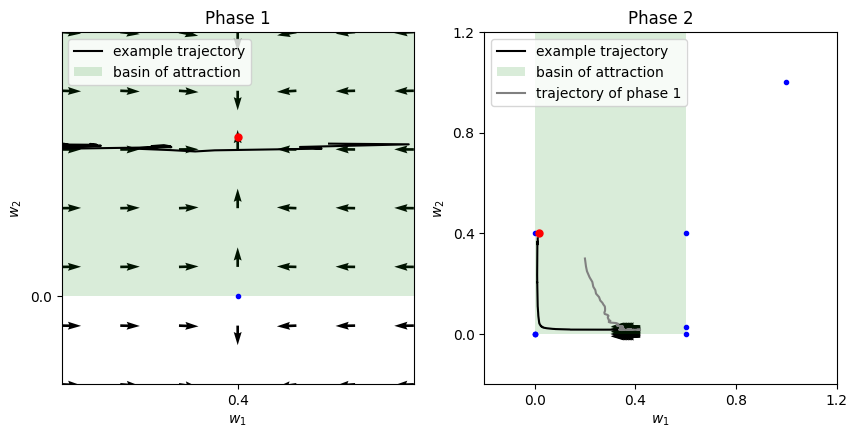

In [9]:
initial_conditions = [(x,y) for x in np.linspace(0.38, 0.42, 7) for y in np.linspace(-0.01, 0.03,  7)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))

R1, R2 = 1, -1.5
critical_points = get_stationary_points(R1, R2)
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

make_plot(ax1, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectory)

R2, R1 = 1, -1.5
critical_points = get_stationary_points(R1, R2)
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

make_plot(ax2, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectory)

ax1.set_xlim(0.38, 0.42)
ax1.set_ylim(-0.01, 0.03)



/tmp/ipykernel_7060/3829768346.py:23: RuntimeWarning: invalid value encountered in divide
  vector_field_normalized = np.array(vector_field) /  np.sqrt((np.array(vector_field)**2).sum(axis=1, keepdims=True))


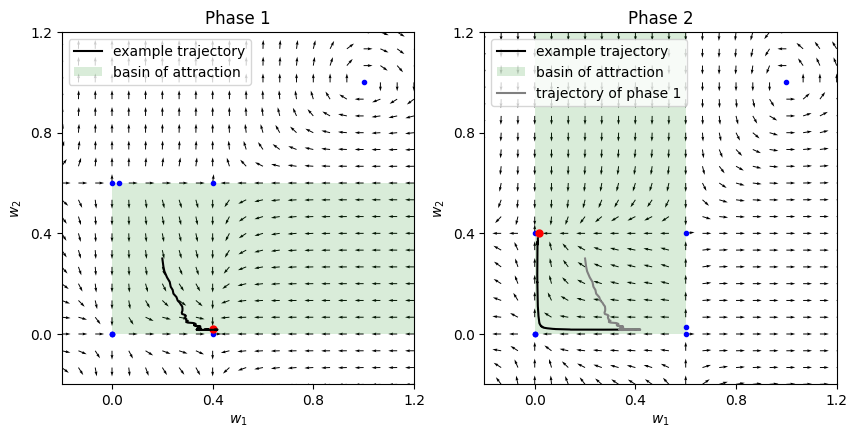

In [10]:
# zoom

initial_conditions = [(x,y) for x in np.linspace(-0.2, 1.2, 22) for y in np.linspace(-0.2,1.2, 22)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12))

R1, R2 = 1, -1.5
critical_points = get_stationary_points(R1, R2)
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

make_plot(ax1, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectory)

R2, R1 = 1, -1.5
critical_points = get_stationary_points(R1, R2)
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

make_plot(ax2, critical_points, initial_conditions, vector_field_normalized, R1, R2, trajectory)


#fig.savefig('stationary_points.pdfi')

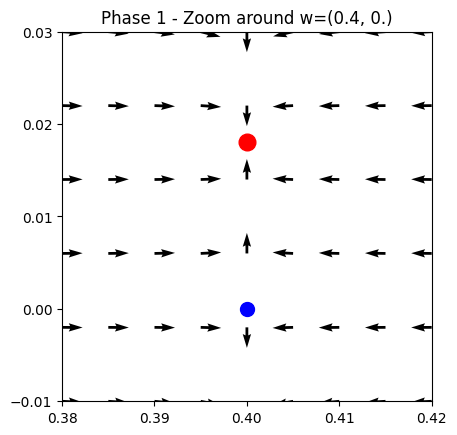

In [50]:
fig, ax = plt.subplots()

R1 = 1
R2 = -1.5

critical_points = get_stationary_points(R1, R2)
initial_conditions = [(x,y) for x in np.linspace(0.38, 0.42, 9) for y in np.linspace(-0.01, 0.03,  6)]
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)


for key in critical_points:


    if (R1==1 and key == "(bary1,theta)") or (R2==1 and key=="(theta,bary2)"):
        color = 'red'
        size=12
    else:
        color = 'blue'
        size=10

    ax.plot(*critical_points[key], 'o', c=color, ms=size)


ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
        vector_field_normalized[:, 0], vector_field_normalized[:,1])

ax.set_aspect('equal')

ax.set_title("Phase 1 - Zoom around w=(0.4, 0.)")

ax.set_xticks([0.38, 0.39, 0.4, 0.41, 0.42])
ax.set_yticks([-0.01, 0., 0.01, 0.02, 0.03])

ax.set_xlim(0.38, 0.42)
ax.set_ylim(-0.01, 0.03)

fig.savefig('zoom_reviewer1_phase1.pdf')

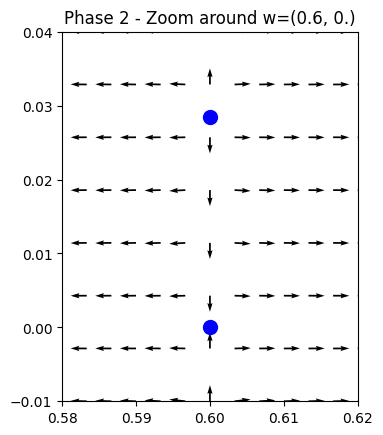

In [51]:
fig, ax = plt.subplots()

R1 = -1.5
R2 = 1

critical_points = get_stationary_points(R1, R2)
initial_conditions = [(x,y) for x in np.linspace(0.58, 0.62, 13) for y in np.linspace(-0.01, 0.04,  8)]
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)


for key in critical_points:


    if (R1==1 and key == "(bary1,theta)") or (R2==1 and key=="(theta,bary2)"):
        color = 'red'
        size=12
    else:
        color = 'blue'
        size=10

    ax.plot(*critical_points[key], 'o', c=color, ms=size)


ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
        vector_field_normalized[:, 0], vector_field_normalized[:,1])

ax.set_aspect('equal')

ax.set_title("Phase 2 - Zoom around w=(0.6, 0.)")

ax.set_xlim(0.58, 0.62)
ax.set_ylim(-0.01, 0.04)

fig.savefig('zoom_reviewer1_phase2.pdf')

In [ ]:
fig, ax = plt.subplots()

R1 = 1
R2 = -1.5

critical_points = get_stationary_points(R1, R2)
initial_conditions = [(x,y) for x in np.linspace(0.38, 0.42, 9) for y in np.linspace(-0.01, 0.03,  6)]
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)


for key in critical_points:


    if (R1==1 and key == "(bary1,theta)") or (R2==1 and key=="(theta,bary2)"):
        color = 'red'
        size=12
    else:
        color = 'blue'
        size=10

    ax.plot(*critical_points[key], 'o', c=color, ms=size)


ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
        vector_field_normalized[:, 0], vector_field_normalized[:,1])

ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])

ax.set_xlim(0.38, 0.42)
ax.set_ylim(-0.01, 0.03)

fig.savefig('zoom_1.pdf')

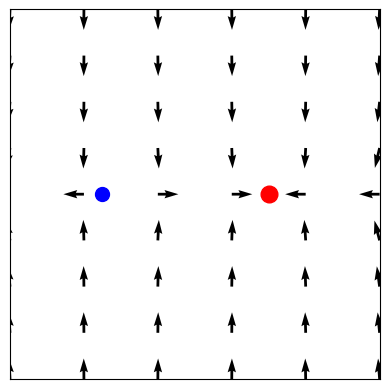

In [12]:
fig, ax = plt.subplots()

R1 = -1.5
R2 = 1

critical_points = get_stationary_points(R1, R2)
initial_conditions = [(x,y) for x in np.linspace(-0.01, 0.03, 6) for y in np.linspace(0.38, 0.42,  9)]
vector_field_normalized = get_vector_field(initial_conditions, R1, R2)

for key in critical_points:


    if (R1==1 and key == "(bary1,theta)") or (R2==1 and key=="(theta,bary2)"):
        color = 'red'
        size=12
    else:
        color = 'blue'
        size=10

    ax.plot(*critical_points[key], 'o', c=color, ms=size)

ax.quiver(np.array(initial_conditions)[:,0],np.array(initial_conditions)[:,1],
        vector_field_normalized[:, 0], vector_field_normalized[:,1])

ax.set_aspect('equal')

ax.set_xticks([])
ax.set_yticks([])

ax.set_ylim(0.38, 0.42)
ax.set_xlim(-0.01, 0.03)

fig.savefig('zoom_2.pdf')